# Algoritmos de Optimización - Actividad Guiada 2
Nombre: ***Josseph Yaakob Catagua Cobos*** <br>
Enlace: [GitHub](https://github.com/HikariJY/03MIAR_04_A_2024-25_Algoritmos-de-Optimizacion)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import random

## Actividad Propuesta

**¿Te atreves a optimizar la función?:**
$$f(x)=sin(1/2 * x^2 - 1/4 * y^2 + 3) * cos(2*x + 1 - e^y)$$ <br>
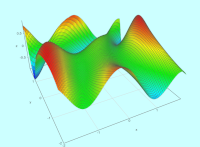

In [3]:
#Definimos la funcion
f = lambda X: math.sin(1/2*X[0]**2 - 1/4*X[1]**2 + 3)*math.cos(2*X[0] + 1 - math.exp(X[1]))

El valor de la función en el punto x = [1, 2] es ['-0.8804', '3.9385']


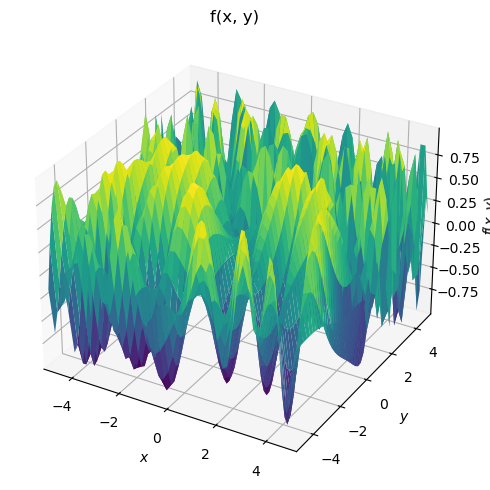

In [4]:
# Definición de las variables
X, Y = sp.symbols('x y')

# Definición de la función
f_xy = sp.sin(1/2*X**2 - 1/4*Y**2 + 3) * sp.cos(2*X + 1 - sp.exp(Y))
f_xy_lambda = sp.lambdify([X, Y], f_xy, 'numpy')

# Cálculo del gradiente
df_xy = [sp.diff(f_xy, X), sp.diff(f_xy, Y)]
df_xy_lambda = [sp.lambdify([X, Y], df, 'numpy') for df in df_xy]

x_val = [1, 2]
df_res = [df(*x_val) for df in df_xy_lambda]
df_res_str = [f'{df:.4f}' for df in df_res]
print(f'El valor de la función en el punto x = {x_val} es {df_res_str}')

sp.plotting.plot3d(f_xy,
       (X, -5, 5), (Y, -5, 5),
       title='f(x, y)',
       size=(5, 5))

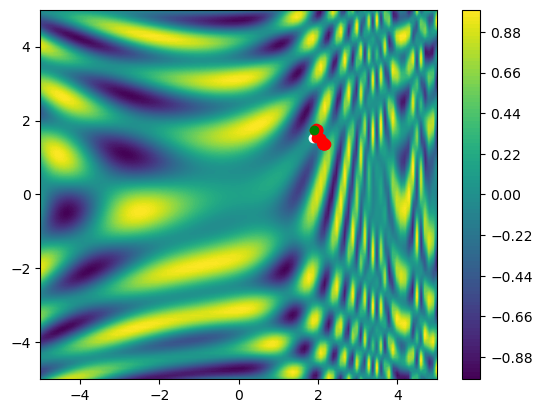

El valor de la función en el punto x = ['1.9120', '1.7368'] es -0.5268


In [5]:
resolucion = 100
rango = 5.0

X_value = np.linspace(-rango, rango, resolucion)
Y_value = np.linspace(-rango, rango, resolucion)
Z_value = np.zeros((resolucion, resolucion))

for ix, nx in enumerate(X_value):
    for iy, ny in enumerate(Y_value):
        val = [nx, ny]
        Z_value[ix, iy] = f_xy_lambda(*val)

plt.contourf(X_value, Y_value, Z_value, resolucion)
plt.colorbar()

P = [random.uniform(-5, 5), random.uniform(-5, 5)]
plt.plot(P[0], P[1], "o", c="white")

TA = 0.1

#Iteraciones:50
for _ in range(50):
    grad = [df(*P) for df in df_xy_lambda]
    #print(P, grad)
    P[0], P[1] = P[0] - TA*grad[0], P[1] - TA*grad[1]
    plt.plot(P[0], P[1], "o", c="red")

plt.plot(P[0], P[1], "o", c="green")
plt.show()

P_str = [f'{p:.4f}' for p in P]
print(f'El valor de la función en el punto x = {P_str} es {f_xy_lambda(*P):.4f}')

## Actividades en Clases

### Programación Dinámica. Viaje por el rio
* **Definición**: Es posible dividir el problema en subproblemas más pequeños, guardando las soluciones para ser utilizadas más adelante.
* **Características** que permiten identificar problemas aplicables:<br>
    * Es posible almacenar soluciones de los subproblemas para ser utilizados más adelante<br>
    * Debe verificar el principio de optimalidad de Bellman: “en una secuencia optima de decisiones, toda sub-secuencia también es óptima” (*)<br>
    * La necesidad de guardar la información acerca de las soluciones parciales unido a la recursividad provoca la necesidad de preocuparnos por la complejidad espacial (cuantos recursos de espacio usaremos)<br>

#### Problema<br>
En un río hay **$n$ embarcaderos y debemos desplazarnos río abajo desde un embarcadero a otro. Cada embarcadero tiene precios diferentes para ir de un embarcadero a otro situado más abajo. Para ir del embarcadero $i$ al $j$, puede ocurrir que sea más barato hacer un trasbordo por un embarcadero intermedio $k$. El problema consiste en determinar la combinación más barata.

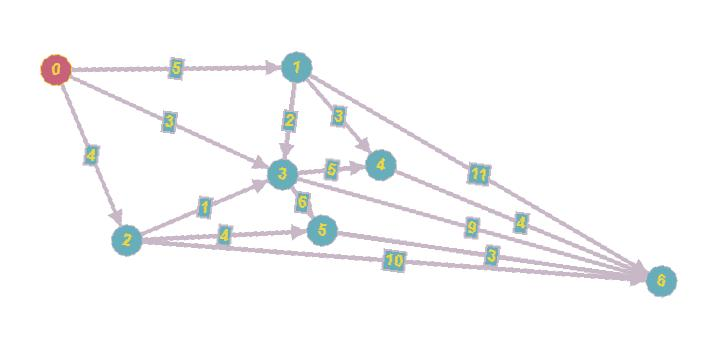
* Consideramos una tabla $TARIFAS(i,j)$ para almacenar todos los precios que nos ofrecen los embarcaderos.<br>
* Si no es posible ir desde $i$ a $j$ daremos un valor alto para garantizar que ese trayecto no se va a elegir en la ruta óptima(modelado habitual para restricciones)

In [6]:
#Viaje por el rio - Programación dinámica
################################################################################
TARIFAS = [
    [0, 5, 4, 3, 999, 999, 999],   #desde nodo 0
    [999, 0, 999, 2, 3, 999, 11],  #desde nodo 1
    [999, 999, 0, 1, 999, 4, 10], #desde nodo 2
    [999, 999, 999, 0, 5, 6, 9],
    [999, 999, 999, 999, 0, 999, 4],
    [999, 999, 999, 999, 999, 0, 3],
    [999, 999, 999, 999, 999, 999, 0]
]

for tarifa in np.array(TARIFAS): print(tarifa)

[  0   5   4   3 999 999 999]
[999   0 999   2   3 999  11]
[999 999   0   1 999   4  10]
[999 999 999   0   5   6   9]
[999 999 999 999   0 999   4]
[999 999 999 999 999   0   3]
[999 999 999 999 999 999   0]


In [7]:
#Calculo de la matriz de PRECIOS y RUTAS
#  PRECIOS - contiene la matriz del mejor precio para ir de un nodo a otro
#  RUTAS   - contiene los nodos intermedios para ir de un nodo a otro
################################################################
def Precios(TARIFAS):
    ################################################################
    #Total de Nodos
    N = len(TARIFAS[0])
    #Inicialización de la tabla de precios
    PRECIOS = [[9999]*N for i in [9999]*N]  #nxn
    RUTA = [[""]*N for i in [""]*N]
    #Se recorren todos los nodos con dos bucles(origen - destino)
    #  para ir construyendo la matriz de PRECIOS
    for i in range(N - 1):
        for j in range(i + 1, N):
            MIN = TARIFAS[i][j]
            RUTA[i][j] = i
            for k in range(i, j):
                if PRECIOS[i][k] + TARIFAS[k][j] < MIN:
                    MIN = min(MIN, PRECIOS[i][k] + TARIFAS[k][j])
                    RUTA[i][j] = k
                PRECIOS[i][j] = MIN
    return PRECIOS, RUTA

In [8]:
PRECIOS, RUTAS = Precios(TARIFAS)
#print(PRECIOS[0][6])

print("PRECIOS")
for precio in np.array(PRECIOS): print(precio)

print("\nRUTA")
for ruta in np.array(RUTAS): print(ruta)

PRECIOS
[9999    5    4    3    8    8   11]
[9999 9999  999    2    3    8    7]
[9999 9999 9999    1    6    4    7]
[9999 9999 9999 9999    5    6    9]
[9999 9999 9999 9999 9999  999    4]
[9999 9999 9999 9999 9999 9999    3]
[9999 9999 9999 9999 9999 9999 9999]

RUTA
['' '0' '0' '0' '1' '2' '5']
['' '' '1' '1' '1' '3' '4']
['' '' '' '2' '3' '2' '5']
['' '' '' '' '3' '3' '3']
['' '' '' '' '' '4' '4']
['' '' '' '' '' '' '5']
['' '' '' '' '' '' '']


In [9]:
#Calculo de la ruta usando la matriz RUTA
def calcular_ruta(RUTA, desde, hasta):
  if desde == RUTA[desde][hasta]:
  #if desde == hasta:
    #print("Ir a :" + str(desde))
    return desde
  else:
    return str(calcular_ruta(RUTA, desde, RUTA[desde][hasta])) + ',' + str(RUTA[desde][hasta])

print("\nLa ruta es:")
calcular_ruta(RUTAS, 0, 6)


La ruta es:


'0,2,5'

In [10]:
#Asignacion de tareas - Ramificación y Poda
################################################################################
COSTES=[
    [11, 12, 18, 40],
    [14, 15, 13, 22],
    [11, 17, 19, 23],
    [17, 14, 20, 28]
] # n Tareas x m Agentes

In [11]:
#Calculo del valor de una solucion parcial
def valor(S,COSTES):
    VALOR = 0
    for i in range(len(S)):
        VALOR += COSTES[S[i]][i]
    return VALOR

valor((3,2,  ),COSTES)

34

In [13]:
#Coste inferior para soluciones parciales
#  (1,3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1

def CI(S,COSTES):
    VALOR = 0
    #Valores establecidos
    for i in range(len(S)):
        VALOR += COSTES[i][S[i]]
    #Estimacion
    for i in range( len(S), len(COSTES)   ):
        VALOR += min( [ COSTES[j][i] for j in range(len(S), len(COSTES))  ])
    return VALOR

def CS(S,COSTES):
    VALOR = 0
    #Valores establecidos
    for i in range(len(S)):
        VALOR += COSTES[i][S[i]]
    #Estimacion
    for i in range( len(S), len(COSTES)   ):
        VALOR += max( [ COSTES[j][i] for j in range(len(S), len(COSTES))  ])
    return VALOR

CI((0, 1), COSTES)

68

In [14]:
#Genera tantos hijos como como posibilidades haya para la siguiente elemento de la tupla
#(0,) -> (0,1), (0,2), (0,3)
def crear_hijos(NODO, N):
    HIJOS = []
    for i in range(N):
        if i not in NODO:
            HIJOS.append({'s':NODO + (i,)})
    return HIJOS

In [15]:
crear_hijos((0,), 4)

[{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]

In [16]:
def ramificacion_y_poda(COSTES):
    #Construccion iterativa de soluciones(arbol). En cada etapa asignamos un agente(ramas).
    #Nodos del grafo  { s:(1,2),CI:3,CS:5  }
    #print(COSTES)
    DIMENSION = len(COSTES)
    MEJOR_SOLUCION = tuple(i for i in range(len(COSTES)))
    CotaSup = valor(MEJOR_SOLUCION,COSTES)
    #print("Cota Superior:", CotaSup)
    
    NODOS = []
    NODOS.append({'s':(), 'ci':CI((),COSTES)})
    
    iteracion = 0
    
    while(len(NODOS) > 0):
        iteracion += 1
        
        nodo_prometedor = [ min(NODOS, key=lambda x:x['ci']) ][0]['s']
        #print("Nodo prometedor:", nodo_prometedor)
        
        #Ramificacion
        #Se generan los hijos
        HIJOS = [{'s':x['s'], 'ci':CI(x['s'], COSTES)} for x in crear_hijos(nodo_prometedor, DIMENSION)]
        
        #Revisamos la cota superior y nos quedamos con la mejor solucion si llegamos a una solucion final
        NODO_FINAL = [x for x in HIJOS if len(x['s']) == DIMENSION  ]
        if len(NODO_FINAL ) >0:
            #print("\n********Soluciones:",  [x for x in HIJOS if len(x['s']) == DIMENSION  ] )
            if NODO_FINAL[0]['ci'] < CotaSup:
                CotaSup = NODO_FINAL[0]['ci']
            MEJOR_SOLUCION = NODO_FINAL
            
        #Poda
        HIJOS = [x for x in HIJOS if x['ci'] < CotaSup]

        #Añadimos los hijos
        NODOS.extend(HIJOS)

        #Eliminamos el nodo ramificado
        NODOS = [x for x in NODOS if x['s'] != nodo_prometedor]
    print("La solucion final es:" ,MEJOR_SOLUCION , " en " , iteracion , " iteraciones" , " para dimension: " ,DIMENSION  )

ramificacion_y_poda(COSTES)

La solucion final es: [{'s': (0, 2, 1, 3), 'ci': 69}]  en  10  iteraciones  para dimension:  4


### Descenso del gradiente

Vamos a buscar el minimo de la funcion paraboloide : $$f(x) =  x² + y²$$
Obviamente se encuentra en $(x,y)=(0,0)$ pero probaremos como llegamos a él a través del descenso del gradiante.

In [18]:
#Definimos la funcion
#Paraboloide
f  = lambda X:      X[0]**2 + X[1]**2    #Funcion
df = lambda X: [2*X[0] , 2*X[1]]         #Gradiente

df([1,2])

[2, 4]

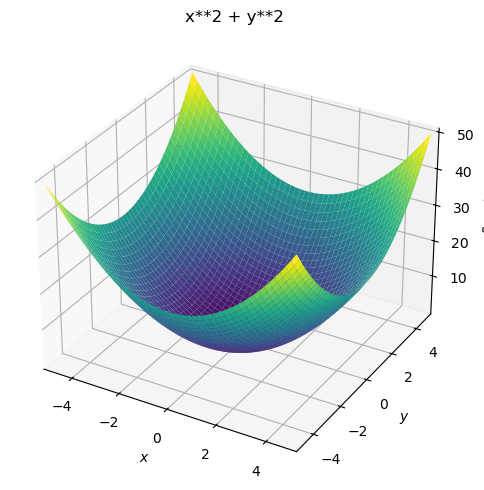

In [19]:
x, y = sp.symbols('x y')
sp.plotting.plot3d(x**2 + y**2,
       (x, -5, 5), (y, -5, 5),
       title='x**2 + y**2',
       size=(5, 5))

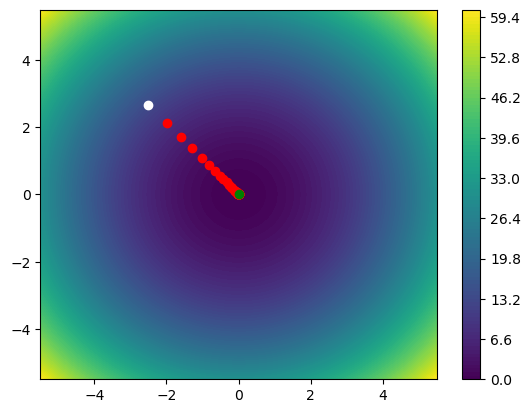

Solucion: [-3.566966031059799e-05, 3.817415036516358e-05] 2.7295904227755682e-09


In [20]:
#Prepara los datos para dibujar mapa de niveles de Z
resolucion = 100
rango=5.5

X = np.linspace(-rango, rango, resolucion)
Y = np.linspace(-rango, rango, resolucion)
Z = np.zeros((resolucion, resolucion))
for ix, x in enumerate(X):
  for iy, y in enumerate(Y):
    Z[iy, ix] = f([x, y])

#Pinta el mapa de niveles de Z
plt.contourf(X, Y, Z, resolucion)
plt.colorbar()

#Generamos un punto aleatorio inicial y pintamos de blanco
P = [random.uniform(-5,5), random.uniform(-5,5)]
plt.plot(P[0], P[1], "o", c="white")

#Tasa de aprendizaje. Fija. Sería más efectivo reducirlo a medida que nos acercamos.
TA=0.1

#Iteraciones:50
for _ in range(50):
  grad = df(P)
  #print(P,grad)
  P[0], P[1] = P[0] - TA*grad[0], P[1] - TA*grad[1]
  plt.plot(P[0], P[1], "o", c="red")

#Dibujamos el punto final y pintamos de verde
plt.plot(P[0], P[1], "o", c="green")
plt.show()
print("Solucion:" ,P ,f(P))

## FIN